In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime
from datetime import date, time
from dateutil.parser import parse

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect,desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
inspector = inspect(engine)
# Using the inspector to print the column names within the "measurement" table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Using the inspector to print the column names within the "station" table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
#Show five rows data of Measurement table
session.query(Measurement.id,Measurement.station,Measurement.date,Measurement.prcp,Measurement.tobs).limit(5).all()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
last_date= list(np.ravel(session.query(func.max(Measurement.date)).all()))
last_date = parse(last_date[0])
#Calculate the first date of last 12 months of the Measurement data 
first_date = last_date - dt.timedelta(days=365)

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
data_prcp = session.query(Measurement.station,Measurement.date,Measurement.prcp)\
.filter(Measurement.date > str(first_date-dt.timedelta(days=1)))\
.order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
PRCP_data = pd.DataFrame(data_prcp,columns=["Station","Date","PRCP"])
#Fill NaN with zero
PRCP_data.fillna({'PRCP': 0},inplace=True)


# Rain (PRCP) Analysis

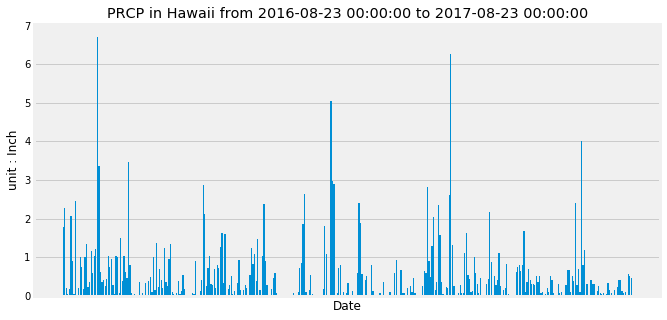

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(PRCP_data.Date, PRCP_data.PRCP)
ax.get_xaxis().set_ticks([])
ax.set(xlabel='Date', ylabel='unit : Inch',title = f'PRCP in Hawaii from {first_date} to {last_date}')
plt.savefig("Images/PRCP_station.png")

In [16]:
#The summary statistics for the precipitation data
PRCP_data.describe()

,PRCP
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Station in Hawaii Analysis

In [17]:
#How many stations are available in this dataset?
print(f"There are {session.query(Station.station).group_by(Station.station).count()} stations")

There are 9 stations


In [18]:
# What are the most active stations?
station_count = session.query(Measurement.station,func.count(Measurement.date))\
.filter(Measurement.station == Station.station)\
.group_by(Station.station)\
.order_by(desc(func.count(Measurement.date))).all()

station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
#The lowest temperature recorded, highest temperature recorded, and average temperature of most active station :
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
.filter(Measurement.station == station_count[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

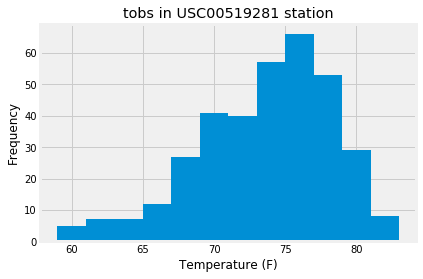

In [33]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Tobs_data = session.query(Measurement.tobs).filter(Measurement.station == station_count[0][0])\
.filter(Measurement.date > str(first_date-dt.timedelta(days=1))).all()

plt.hist(list(np.ravel(Tobs_data)), bins =12)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title(f'tobs in {station_count[0][0]} station')
plt.savefig("Images/tobs_station.png")

# Temperature Analysis

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps(first_date, last_date))

[(58.0, 74.57894736842105, 87.0)]


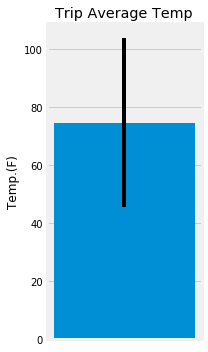

In [34]:
# Plot the results from your previous query as a bar chart. 
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=(3, 5))
plt.bar(1,np.ravel(calc_temps(first_date, last_date))[1],0.1,
        yerr=np.ravel(calc_temps(first_date, last_date))[2]-np.ravel(calc_temps(first_date, last_date))[0])
plt.xticks([])
plt.ylabel("Temp.(F)")
plt.title("Trip Average Temp")
plt.tight_layout()
plt.savefig("Images/avg_trip_temp.png")

# My Trip weather analysis

In [24]:
my_trip_start = dt.datetime(2018, 4, 14)
my_trip_end = dt.datetime(2018, 4, 22)
step = dt.timedelta(days=1)

my_trip_date = []

#Create a sequence days of my trip
while my_trip_start <= my_trip_end:
    my_trip_date.append(my_trip_start.strftime('%Y-%m-%d'))
    my_trip_start += step

In [25]:
past_date = [(parse(my_trip_date[x])- dt.timedelta(days=365)).strftime('%Y-%m-%d') for x in range(len(my_trip_date))]
past_date

['2017-04-14',
 '2017-04-15',
 '2017-04-16',
 '2017-04-17',
 '2017-04-18',
 '2017-04-19',
 '2017-04-20',
 '2017-04-21',
 '2017-04-22']

The rainfall per weather station with previous year's matching dates of my trip.

In [26]:
Total_PRCP_station = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,
                 func.sum(Measurement.prcp))\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date.in_(past_date))\
.group_by(Station.station)\
.order_by(desc(func.sum(Measurement.prcp))).all()

pd.DataFrame(Total_PRCP_station, columns = ["Station","Name","Lat","Lon", "elevation", "total_amount_PRCP"])

,Station,Name,Lat,Lon,elevation,total_amount_PRCP
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,9.61
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,9.44
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,4.64
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,3.52
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2.16
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.91
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00


In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    Args:
        date (str): A date string in the format '%m-%d'
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    """
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()


In [28]:
#Save a list of %m-%d strings in order to calulate the daily normals for my trip
my_trip_date_noyear = [ my_trip_date[x].split("-",1)[1] for x in range(len(my_trip_date))]

normals = [np.ravel(daily_normals(x)) for x in my_trip_date_noyear]
normals

[array([65.  , 72.75, 81.  ]),
 array([61.        , 71.79310345, 79.        ]),
 array([62.        , 71.55357143, 81.        ]),
 array([65.        , 71.93103448, 77.        ]),
 array([67.        , 72.49152542, 77.        ]),
 array([65.        , 72.42105263, 83.        ]),
 array([64.        , 72.73684211, 80.        ]),
 array([66.        , 72.32142857, 78.        ]),
 array([65.        , 72.92727273, 84.        ])]

In [29]:
My_Trip_weather = pd.DataFrame(normals,columns = ["tmin","tavg","tmax"],index = my_trip_date)
My_Trip_weather

,tmin,tavg,tmax
2018-04-14,65.0,72.750000,81.0
2018-04-15,61.0,71.793103,79.0
2018-04-16,62.0,71.553571,81.0
2018-04-17,65.0,71.931034,77.0
2018-04-18,67.0,72.491525,77.0
2018-04-19,65.0,72.421053,83.0
2018-04-20,64.0,72.736842,80.0
2018-04-21,66.0,72.321429,78.0
2018-04-22,65.0,72.927273,84.0


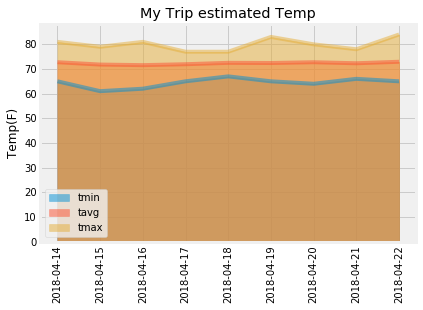

In [35]:
# Plot the daily normals as an area plot with `stacked=False`
My_Trip_weather.plot(kind = "area",stacked=False,grid = True, title="My Trip estimated Temp")
plt.xticks(np.arange(9),my_trip_date,rotation = 90)
plt.ylabel('Temp(F)')
plt.savefig("Images/my_trip_temp.png")